In [29]:
#default_exp discrete


# Utilities for Discrete Inference

This module provides utilities to work with discrete keys and the like for the first two chapters in the book.


In [30]:
# export
import gtsam

from typing import List, Tuple, Callable


## Helper functions

It is currently very annoying to create a set of discrete keys. This is probably because we don't understand pybind11 fully yet. The following makes this easier:

In [31]:
#export
def P(*args):
    """ Create a DiscreteKeys instances from a variable number of DiscreteKey pairs.

    Discrete keys are represented as pairs in Python, with the first element the key and 
    the second element the cardinality of the discrete variable. This function accepts a
    variable number of such pairs and creates a gtsam.DiscreteKeys instance.

    Returns:
        DiscreteKeys: an instance of DiscreteKeys.
    """
    #TODO: We can make life easier by providing variable argument functions in C++ itself.
    dks = gtsam.DiscreteKeys()
    for key in args:
        dks.push_back(key)
    return dks

In [32]:
# Example:
parents = P((0, 4), (1, 3))
print(type(parents))
assert parents.size() == 2

<class 'gtsam.gtsam.DiscreteKeys'>


For creating assignments, we also have this little helper:

In [33]:
#export
def V(values):
    """Convert a dictionary into a DiscreteValues instance.

    Args:
        values (dict): A map from keys to values.

    Returns:
        gtsam.DiscreteValues: an assignment to discrete variables usable by gtsam.
    """
    # TODO: add variable argument operator that takes values in keys order.
    # TODO: allow conversion from dictionary to DiscreteValues.
    a = gtsam.DiscreteValues()
    for key, value in values.items():
        a[key] = value
    return a


## DiscretePrior

Not in GTSAM:

In [34]:
#export
def DiscretePrior(key: int, pmf: str):
    """ A prior on a discrete variable.

    This really just creates a gtsam.DiscreteConditional without parents.
    """
    # TODO: add to GTSAM
    return gtsam.DiscreteConditional(key, P(), pmf)


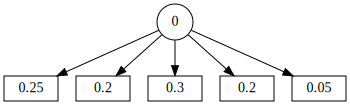

In [35]:
C = 0, 5  # A key is an identifier and a cardinality
prior = DiscretePrior(C, "25/20/30/20/5")
assert not prior.empty()

from gtbook.display import show
# TODO: this does not support formatting yet
show(prior)

In [36]:
prior_probability_for_3 = prior(V({0:3}))
assert prior_probability_for_3 == 0.2

## Domains

We would like to make it easier for people to create discrete variables, with a meaningful name, and meaningful strings associated with discrete values. Below is it possible design:

In [37]:
# export

DiscreteKey = Tuple[int, int]


class Variables:
    """A problem domain for discrete variables."""

    BINARY = ["false", "true"]

    def __init__(self):
        self._variables = {}

    def discrete(self, name: str, domain: List[str]) -> DiscreteKey:
        """Create a variable with given name and discrete domain of named values.

        Args:
            name (str): name of the variable.
            domain (List[str]): names for the different values.

        Returns:
            key: DiscreteKey, i.e., (gtsam.Key, cardinality)
        """
        discreteKey = len(self._variables), len(domain)
        self._variables[discreteKey[0]] = name, domain
        return discreteKey

    def binary(self, name: str) -> DiscreteKey:
        """Create a binary variable with given name.

        Args:
            name (str): name of the variable.

        Returns:
            key: DiscreteKey, i.e., (gtsam.Key, cardinality)
        """
        return self.discrete(name, self.BINARY)

    def name(self, discreteKey: DiscreteKey) -> str:
        """Return name of variable with given discreteKey.

        Args:
            discreteKey (DiscreteKey): (gtsam.Key, cardinality)

        Returns:
            str: name of the variable.
        """
        return self._variables[discreteKey[0]][0]

    def domain(self, discreteKey: DiscreteKey):
        """Return domain of variable with given discreteKey.

        Args:
            discreteKey (DiscreteKey): (gtsam.Key, cardinality)

        Returns:
            str: domain of the variable.
        """
        return self._variables[discreteKey[0]][1]

    def keyFormatter(self) -> Callable:
        """Return a lambda that can be used as KeyFormatter in GTSAM"""
        return lambda key: self._variables[key][0]


Here is an example:

In [38]:
variables = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
C = variables.discrete("Category", categories)

assert variables.name(C) == "Category"
assert variables.domain(C) == categories

Now it can provide a key formatter for us:

In [39]:
keyFormatter = variables.keyFormatter()
assert keyFormatter(C[0]) == "Category"

Binary variables are supported as a special case:

In [41]:
Conductivity = variables.binary("Conductivity")
assert variables.domain(Conductivity) == ["false", "true"]